## **Week 3: Understanding Neural Networks**
### José Manuel López, Alex Martín, Marcos V. Conde

### **Goals**
* Understanding the MLP topology.
* Learn how to extract features from a network.
* Compare learnt features vs with handcrafted features.

### **Experimentation**
* MLP on small images: end to end VS SVM.
    * Different structures: adding layers, image size, etc.
    * Extract features from the output of the last layer and use them as descriptor on SVM
* MLP as dense descriptor: end to end VS BoW.
    * Divide the image into small patches and extract the prediction for each patch and aggregate the final prediction.
    * Take each patch output and apply BoW.

### **Tasks**
<ins>Understanding Networks</ins>
1.  Add/Change layers in NN topology.
2.  Given an image, get the output of a given layer.
3.  Manage to merge multiple outputs from a single image in a end to end network.

<ins>Learnt vs Handcrafted </ins>

4.  Extract a single feature from an input and apply to svm, compare to end to end network.
5.  Extract multiple features from and image and apply BoW, compare to end to end network.

In [1]:
# Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Reshape
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
try:
    from keras.utils import plot_model
except:
    from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [2]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    pass

In [3]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices()[1].physical_device_desc)

device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:26:00.0, compute capability: 8.6


In [4]:
# DEFAULT VARIABLES
colab = False
IMG_SIZE = 32
BATCH_SIZE = 16
EPOCHS = 50
RANDOM_SEED = 42
DATASET_DIR = './MIT_split'
if colab:
  DATASET_DIR = '/content/drive/MyDrive/MIT_split'

# SET SEED TO CONTROL RANDOMNESS
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [5]:
def get_datasets():
        # this is the dataset configuration we will use for training
        # only rescaling
        train_datagen = ImageDataGenerator(
                rescale=1./255,
                horizontal_flip=True)

        # this is the dataset configuration we will use for testing:
        # only rescaling
        test_datagen = ImageDataGenerator(rescale=1./255)

        # this is a generator that will read pictures found in
        # subfolers of 'data/train', and indefinitely generate
        # batches of augmented image data
        train_loader = train_datagen.flow_from_directory(
                DATASET_DIR+'/train',  # this is the target directory
                target_size=(IMG_SIZE, IMG_SIZE),  # all images will be resized to IMG_SIZExIMG_SIZE
                batch_size=BATCH_SIZE,
                classes = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding'],
                class_mode='categorical')  # since we use binary_crossentropy loss, we need categorical labels

        # this is a similar generator, for validation data
        test_loader = test_datagen.flow_from_directory(
                DATASET_DIR+'/test',
                target_size=(IMG_SIZE, IMG_SIZE),
                batch_size=BATCH_SIZE,
                classes = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding'],
                class_mode='categorical')
        
        return train_loader, test_loader

train_loader, test_loader = get_datasets()

Found 1881 images belonging to 8 classes.
Found 807 images belonging to 8 classes.


In [6]:
type(train_loader)

keras.preprocessing.image.DirectoryIterator

In [7]:
# Testing DataLoader and Data Cardinality
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

(16, 32, 32, 3)

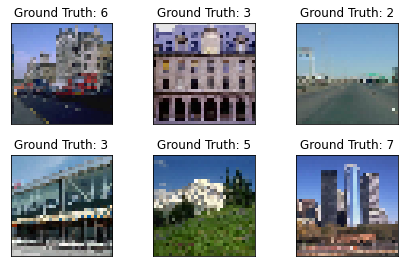

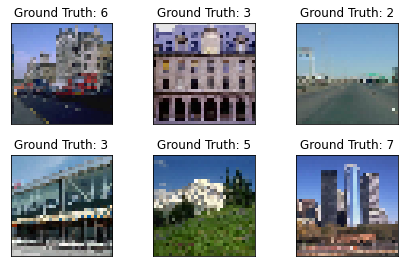

In [8]:
# Plotting some Data to know more about the Dataset
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(np.argmax(example_targets[i])))
  plt.xticks([])
  plt.yticks([])
fig

In [9]:
def build_model(layers, file, info = True):
    model = Sequential()
    model.add(Reshape((IMG_SIZE*IMG_SIZE*3,),input_shape=(IMG_SIZE, IMG_SIZE, 3),name='Flatten'))
    for layer in layers:
        model.add(layer)
    model.add(Dense(units=8, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    if info:
        print(model.summary())
        plot_model(model, to_file=file, show_shapes=True, show_layer_names=True)
    return model

model = build_model([Dense(units=2048, activation='relu'),Dense(units=2048, activation='relu'), Dense(units=1024, activation='relu')], 'modelMLP_1.png')


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 2048)              6293504   
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              4196352   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 8200      
Total params: 12,596,232
Trainable params: 12,596,232
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
history = model.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE)

Epoch 1/50
117/117 [==============================] - 5s 34ms/step - loss: 2.2319 - accuracy: 0.2231 - val_loss: 1.6271 - val_accuracy: 0.3487
Epoch 2/50
117/117 [==============================] - 4s 34ms/step - loss: 1.7030 - accuracy: 0.3550 - val_loss: 1.6248 - val_accuracy: 0.4062
Epoch 3/50
117/117 [==============================] - 4s 33ms/step - loss: 1.6072 - accuracy: 0.4021 - val_loss: 1.6714 - val_accuracy: 0.3675
Epoch 4/50
117/117 [==============================] - 4s 33ms/step - loss: 1.5402 - accuracy: 0.4257 - val_loss: 1.5065 - val_accuracy: 0.4487
Epoch 5/50
117/117 [==============================] - 4s 33ms/step - loss: 1.4481 - accuracy: 0.4842 - val_loss: 1.4586 - val_accuracy: 0.4613
Epoch 6/50
117/117 [==============================] - 4s 33ms/step - loss: 1.3669 - accuracy: 0.5072 - val_loss: 1.5125 - val_accuracy: 0.4625
Epoch 7/50
117/117 [==============================] - 4s 33ms/step - loss: 1.3574 - accuracy: 0.5260 - val_loss: 1.4188 - val_accuracy: 0.4800

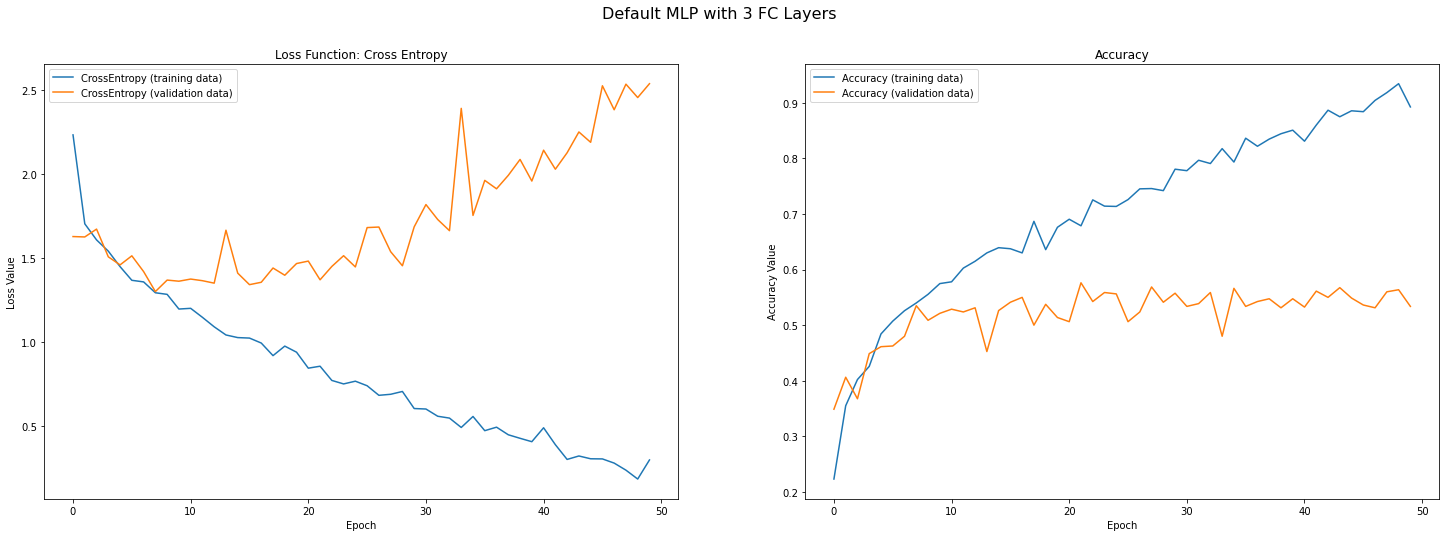

In [11]:
def plot_loss_accuracy(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,8))
    
    fig.suptitle(title, fontsize=16)

    # Plot history: CrossEntropy
    ax1.plot(history.history['loss'], label='CrossEntropy (training data)')
    ax1.plot(history.history['val_loss'], label='CrossEntropy (validation data)')
    ax1.set_title('Loss Function: Cross Entropy')
    ax1.set(xlabel='Epoch', ylabel='Loss Value')
    ax1.legend(loc="upper left")

    # Plot history: Accuracy
    ax2.plot(history.history['accuracy'], label='Accuracy (training data)')
    ax2.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
    ax2.set_title('Accuracy')
    ax2.set(xlabel='Epoch', ylabel='Accuracy Value')
    ax2.legend(loc="upper left")

    plt.show()

plot_loss_accuracy(history, 'Default MLP with 3 FC Layers')

In [12]:
def evaluate_model(model,title):
    print("---"*30)
    loss, score = model.evaluate(train_loader, verbose = 0)
    print("{} Train Score: {:.3f} || Train Loss: {:.3f}".format(title,100*score, loss))
    loss, score = model.evaluate(test_loader, verbose = 0)
    print("{} Test Score: {:.3f} || Test Loss: {:.3f}".format(title,100*score, loss))
    print("---"*30)


### Evaluating changes in Network Topology
We are going to evaluate those changes using different number of layers and different number of neurons. Then Accuracy and Loss through epochs will be displayed for both training and test datasets.

* The first experiment will be increasing the number of layers. We have 3 FC layers at default MLP: we are going to add 4, 5, 6 layers and see the results.
    * We follow a power of 2 rule (32, 64, 128, 256, ...) for the number of neurons.

In [13]:
# 6 FC layers
model_6 = build_model([Dense(units=2048, activation='relu'),Dense(units=1024, activation='relu'), Dense(units=512, activation='relu'),
                       Dense(units=256, activation='relu'), Dense(units=128, activation='relu'), Dense(units=64, activation='relu'), Dense(units=32, activation='relu')], 'modelMLP_6.png')

# Training
history_6 = model_6.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 2048)              6293504   
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_9 (Dense)              (None, 64)               

In [14]:
# 5 FC layers
model_5 = build_model([Dense(units=2048, activation='relu'),Dense(units=1024, activation='relu'), Dense(units=512, activation='relu'),
                       Dense(units=256, activation='relu'), Dense(units=128, activation='relu'), Dense(units=64, activation='relu')], 'modelMLP_5.png')

# Training
history_5 = model_5.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 2048)              6293504   
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_14 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_15 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_16 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_17 (Dense)             (None, 64)               

In [15]:
# 4 FC layers
model_4 = build_model([Dense(units=2048, activation='relu'),Dense(units=1024, activation='relu'), Dense(units=512, activation='relu'),
                       Dense(units=256, activation='relu'), Dense(units=128, activation='relu')], 'modelMLP_4.png')
# Training
history_4 = model_4.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 2048)              6293504   
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_21 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_23 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_24 (Dense)             (None, 8)                

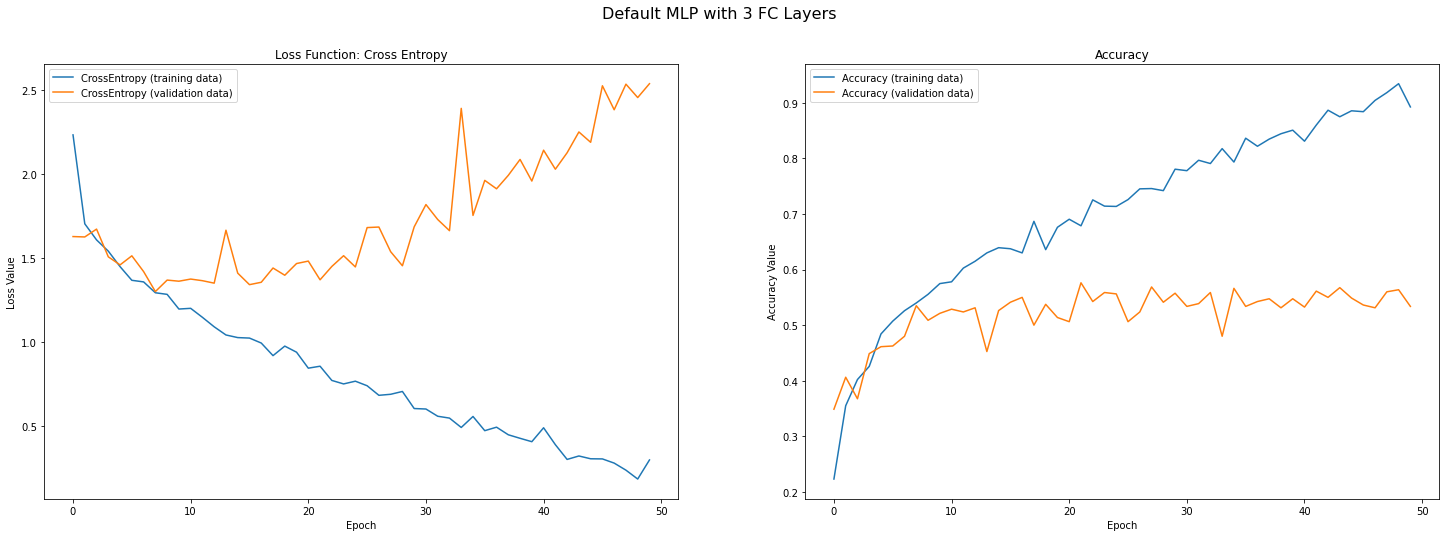

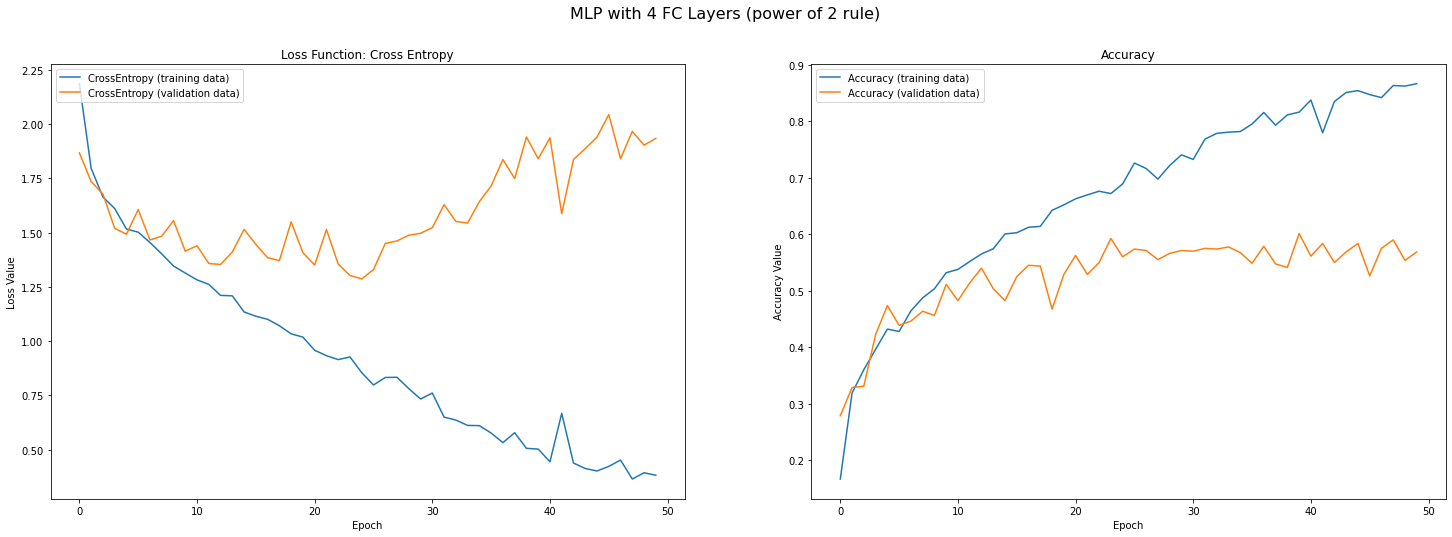

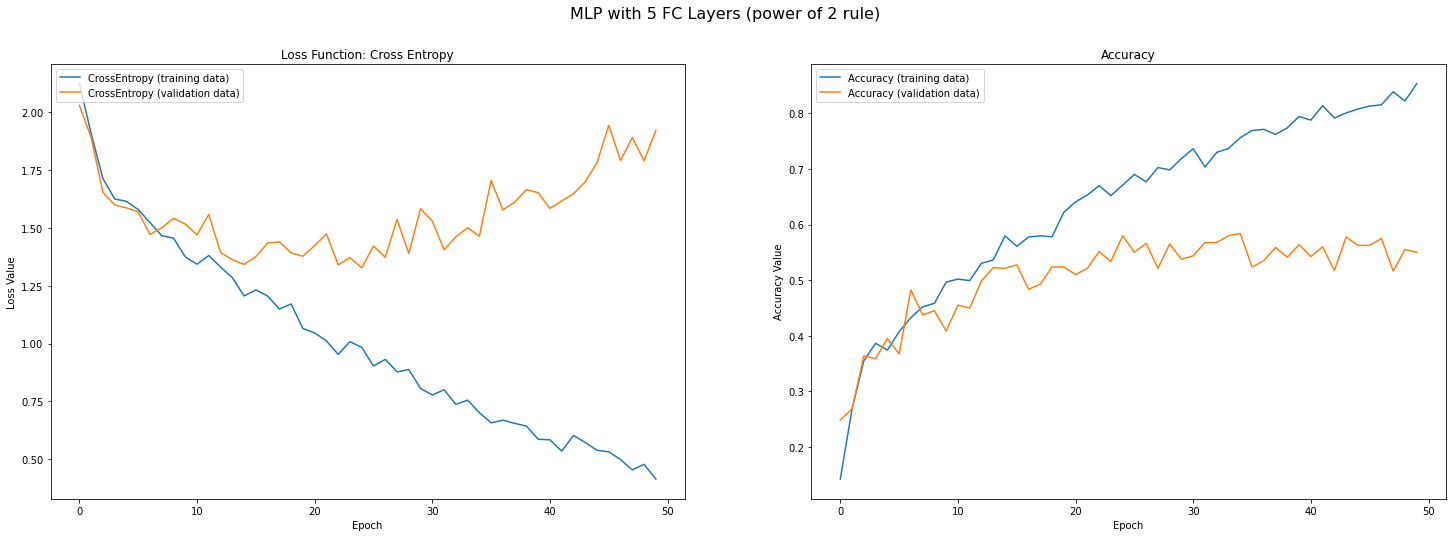

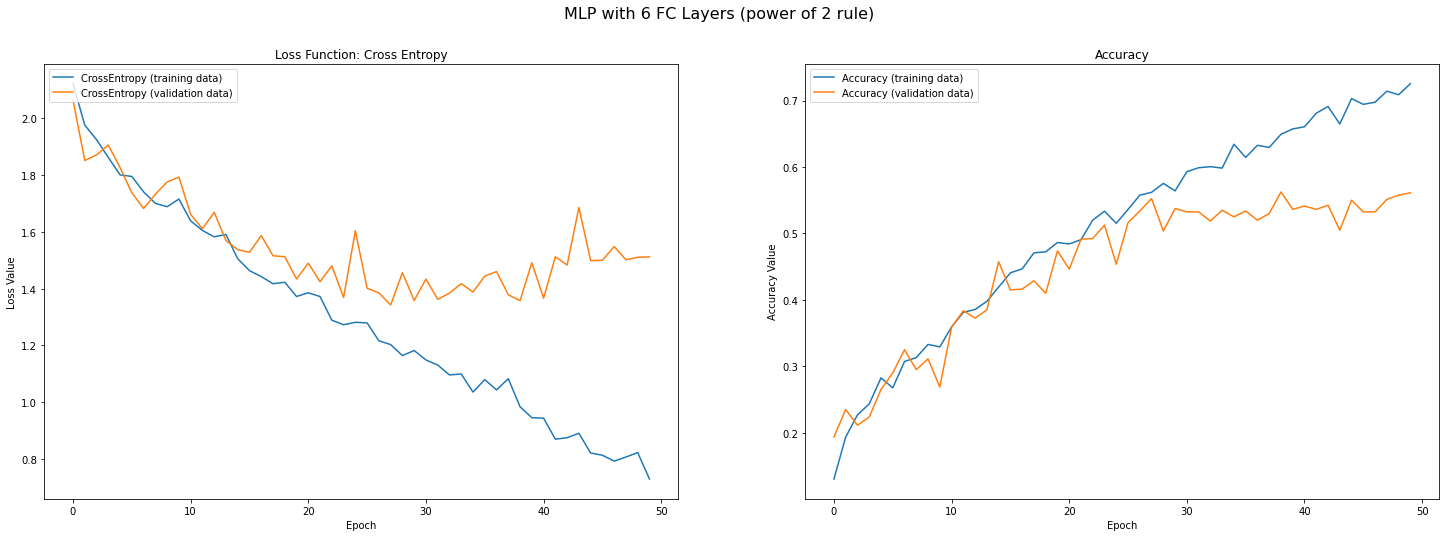

In [16]:
plot_loss_accuracy(history, 'Default MLP with 3 FC Layers')
plot_loss_accuracy(history_4, 'MLP with 4 FC Layers (power of 2 rule)')
plot_loss_accuracy(history_5, 'MLP with 5 FC Layers (power of 2 rule)')
plot_loss_accuracy(history_6, 'MLP with 6 FC Layers (power of 2 rule)')

In [17]:
evaluate_model(model, "Default (Model 3)")
evaluate_model(model_4, "Model 4")
evaluate_model(model_5, "Model 5")
evaluate_model(model_6, "Model 6")

------------------------------------------------------------------------------------------
Default (Model 3) Train Score: 88.198 || Train Loss: 0.311
Default (Model 3) Test Score: 53.656 || Test Loss: 2.519
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Model 4 Train Score: 88.942 || Train Loss: 0.305
Model 4 Test Score: 57.001 || Test Loss: 1.923
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Model 5 Train Score: 83.945 || Train Loss: 0.443
Model 5 Test Score: 55.019 || Test Loss: 1.945
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Model 6 Train Score: 75.758 || Train Loss: 0.684
Model 


*   Now we are going to try the same number of layers but increasing the dense layers (instead of 1024, 512, 128, 64, ... we go for 1024, 1024, 1024, ...).

In [18]:
# Default but more density depth
model_4_big = build_model([Dense(units=2048, activation='relu'),Dense(units=2048, activation='relu'), Dense(units=1024, activation='relu'), Dense(units=1024, activation='relu')], 'modelMLP_4_big.png')
# Training
history_4_big = model_4_big.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 2048)              6293504   
_________________________________________________________________
dense_26 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_27 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_28 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_29 (Dense)             (None, 8)                 8200      
Total params: 13,645,832
Trainable params: 13,645,832
Non-trainable params: 0
__________________________________________

In [19]:
# Default but more density depth
model_5_big = build_model([Dense(units=2048, activation='relu'),Dense(units=2048, activation='relu'), Dense(units=1024, activation='relu'),
                           Dense(units=1024, activation='relu'), Dense(units=1024, activation='relu')], 'modelMLP_5_big.png')
# Training
history_5_big = model_5_big.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 2048)              6293504   
_________________________________________________________________
dense_31 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_32 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_33 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_34 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_35 (Dense)             (None, 8)                

In [20]:
# Default but more density depth
model_6_big = build_model([Dense(units=2048, activation='relu'),Dense(units=2048, activation='relu'), Dense(units=1024, activation='relu'),
                           Dense(units=1024, activation='relu'), Dense(units=1024, activation='relu')], 'modelMLP_6_big.png')
# Training
history_6_big = model_6_big.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 2048)              6293504   
_________________________________________________________________
dense_37 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_38 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dense_39 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_40 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_41 (Dense)             (None, 8)                

In [ ]:
# Default but more density depth
model_10_big = build_model([Dense(units=1024, activation='relu') for i in range(10)], 'modelMLP_10_big.png')
# Training
history_10_big = model_10_big.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

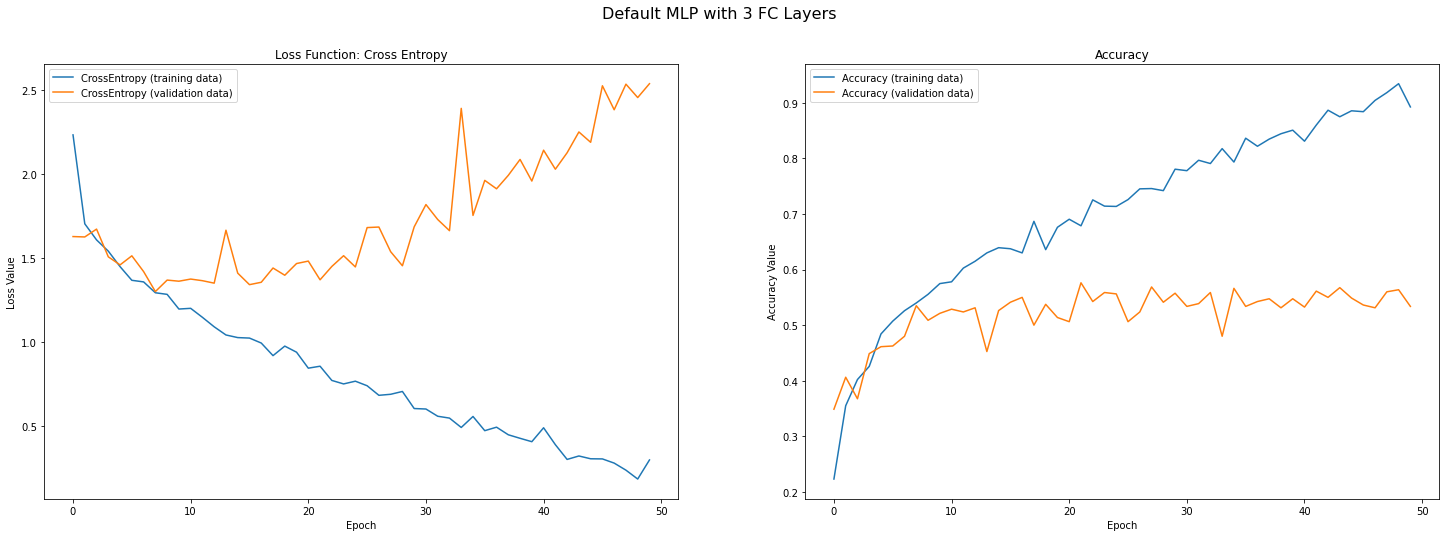

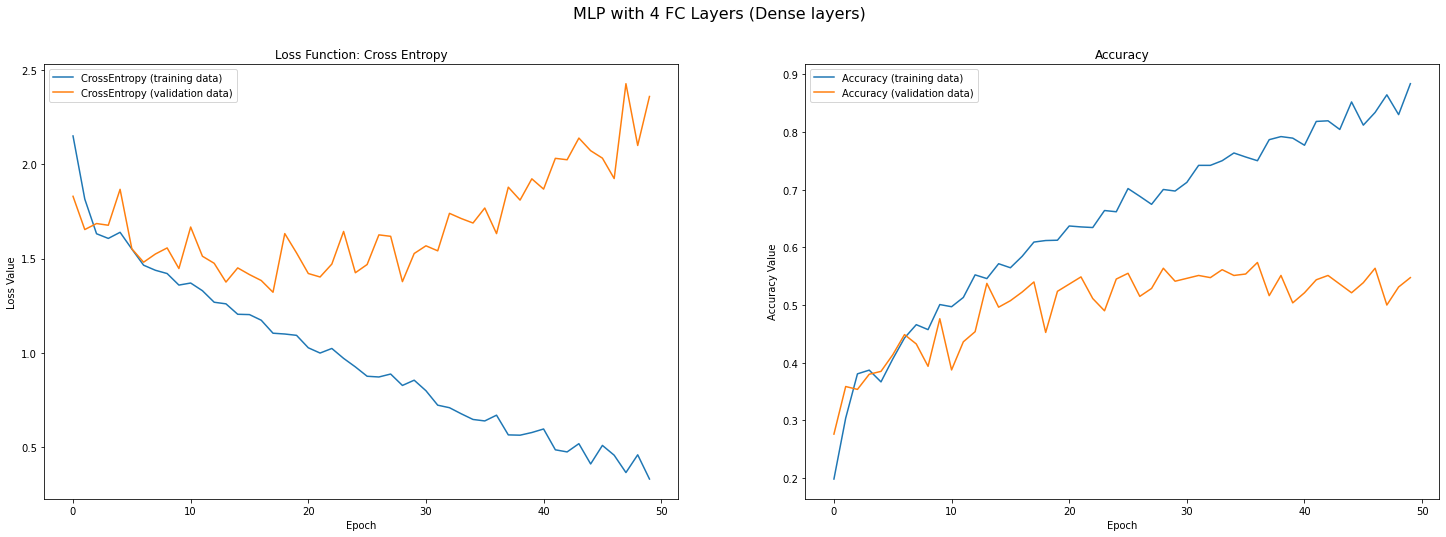

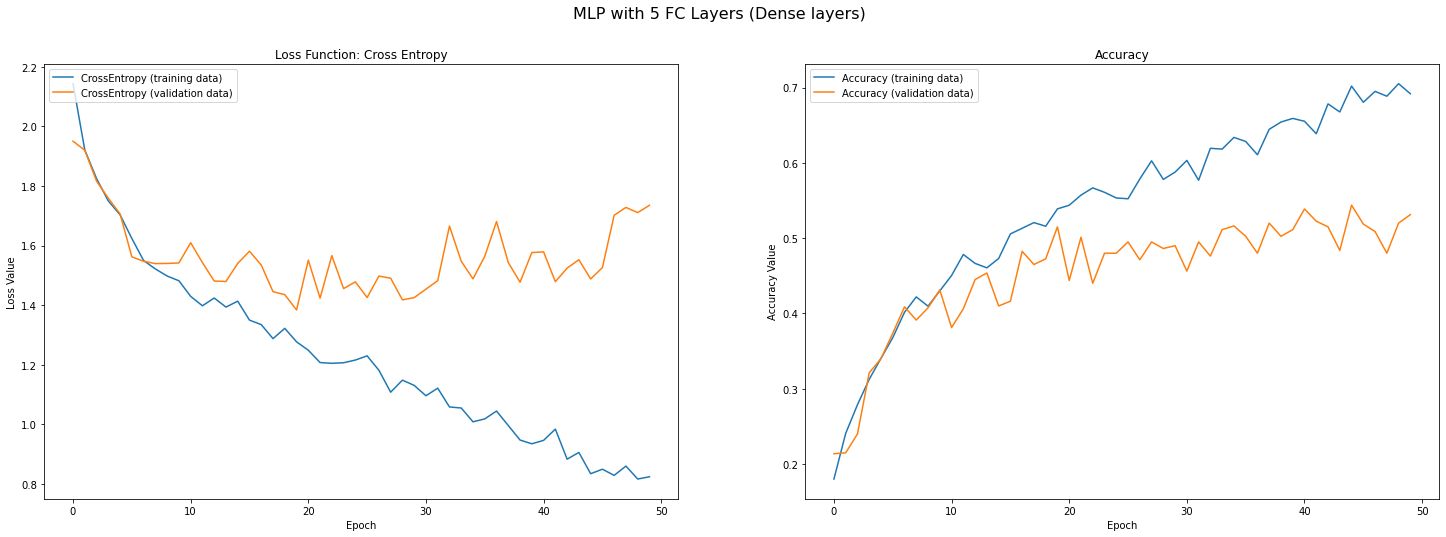

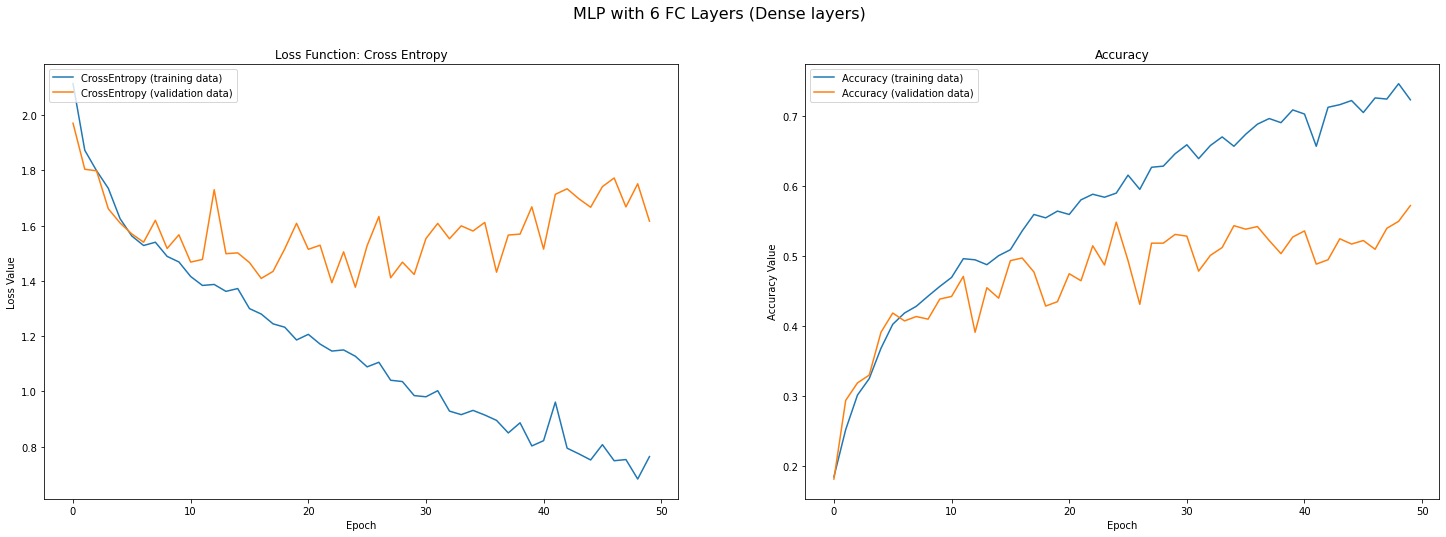

In [21]:
plot_loss_accuracy(history, 'Default MLP with 3 FC Layers')
plot_loss_accuracy(history_4_big, 'MLP with 4 FC Layers (Dense layers)')
plot_loss_accuracy(history_5_big, 'MLP with 5 FC Layers (Dense layers)')
plot_loss_accuracy(history_6_big, 'MLP with 6 FC Layers (Dense layers)')
plot_loss_accuracy(history_10_big, 'MLP with 10 FC Layers (Dense layers)')

In [22]:
evaluate_model(model, "Default (Model 3)")
evaluate_model(model_4_big, "Model 4 Big")
evaluate_model(model_5_big, "Model 5 Big")
evaluate_model(model_6_big, "Model 6 Big")
evaluate_model(model_10_big, "Model 10 Big")

------------------------------------------------------------------------------------------
Default (Model 3) Train Score: 88.676 || Train Loss: 0.307
Default (Model 3) Test Score: 53.656 || Test Loss: 2.519
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Model 4 Big Train Score: 90.112 || Train Loss: 0.257
Model 4 Big Test Score: 54.647 || Test Loss: 2.371
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Model 5 Big Train Score: 72.568 || Train Loss: 0.703
Model 5 Big Test Score: 53.160 || Test Loss: 1.741
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
Model 6 Big Train Score: 80.755 || Trai

## 

### Results
In the both scenarios we see a big overfitting of all models 80~90% for training accuracy while 50~60% for testing accuracy.
* In the first scenario (using power of 2 bases) the most performant is Model 4 with a Test Score of 57.001%
* In the second scenario (increasing number of dense layers) the most performant is Model 6 with also a Test Score of 57.001%
In the end all models perform similar but those are the best.
We also tried a more extreme case (10 layers of 1024 neurons) that resulted in worst performance.

So we can extract that the number of layers it's important: few layers may not be enough to learn about the data and make a proper classification while very large numbers also leads to a bad performance.

--------------------------------------------------------------------------
* Now we are going to take the best model (Model 6) and play with the number of neurons to see their impact in the model.

In [25]:
# Adding 6144
model_6_big_6144 = build_model([Dense(units=6144, activation='relu'),Dense(units=6144, activation='relu'), Dense(units=6144, activation='relu'),
                           Dense(units=6144, activation='relu'), Dense(units=6144, activation='relu')], 'model_6_big_6144.png')
# Training
history_6_big_6144 = model_6_big_6144.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_42 (Dense)             (None, 6144)              18880512  
_________________________________________________________________
dense_43 (Dense)             (None, 6144)              37754880  
_________________________________________________________________
dense_44 (Dense)             (None, 6144)              37754880  
_________________________________________________________________
dense_45 (Dense)             (None, 6144)              37754880  
_________________________________________________________________
dense_46 (Dense)             (None, 6144)              37754880  
_________________________________________________________________
dense_47 (Dense)             (None, 8)                

In [26]:
# Adding 4096
model_6_big_4096 = build_model([Dense(units=4096, activation='relu'),Dense(units=4096, activation='relu'), Dense(units=4096, activation='relu'),
                           Dense(units=4096, activation='relu'), Dense(units=4096, activation='relu')], 'model_6_big_4096.png')
# Training
history_6_big_4096 = model_6_big_4096.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 4096)              12587008  
_________________________________________________________________
dense_49 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_50 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_51 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_52 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dense_53 (Dense)             (None, 8)                

In [27]:
# Adding 2048
model_6_big_2048 = build_model([Dense(units=2048, activation='relu'),Dense(units=2048, activation='relu'), Dense(units=2048, activation='relu'),
                           Dense(units=2048, activation='relu'), Dense(units=2048, activation='relu')], 'model_6_big_2048.png')
# Training
history_6_big_2048 = model_6_big_2048.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 2048)              6293504   
_________________________________________________________________
dense_55 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_56 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_57 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_58 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dense_59 (Dense)             (None, 8)                

In [28]:
# Adding 1024
model_6_big_1024 = build_model([Dense(units=1024, activation='relu'),Dense(units=1024, activation='relu'), Dense(units=1024, activation='relu'),
                           Dense(units=1024, activation='relu'), Dense(units=1024, activation='relu')], 'model_6_big_1024.png')
# Training
history_6_big_1024 = model_6_big_1024.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_60 (Dense)             (None, 1024)              3146752   
_________________________________________________________________
dense_61 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_62 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_63 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_64 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_65 (Dense)             (None, 8)               

In [29]:
# Adding 512
model_6_big_512 = build_model([Dense(units=512, activation='relu'),Dense(units=512, activation='relu'), Dense(units=512, activation='relu'),
                           Dense(units=512, activation='relu'), Dense(units=512, activation='relu')], 'model_6_big_512.png')
# Training
history_6_big_512 = model_6_big_512.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_66 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dense_67 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_68 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_69 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_70 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_71 (Dense)             (None, 8)               

In [30]:
# Adding 256
model_6_big_256 = build_model([Dense(units=256, activation='relu'),Dense(units=256, activation='relu'), Dense(units=256, activation='relu'),
                           Dense(units=256, activation='relu'), Dense(units=256, activation='relu')], 'model_6_big_256.png')
# Training
history_6_big_256 = model_6_big_256.fit(train_loader,steps_per_epoch=1881 // BATCH_SIZE, epochs=EPOCHS, validation_data=test_loader, validation_steps=807 // BATCH_SIZE, verbose = 0)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Flatten (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_72 (Dense)             (None, 256)               786688    
_________________________________________________________________
dense_73 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_74 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_75 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_76 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_77 (Dense)             (None, 8)               

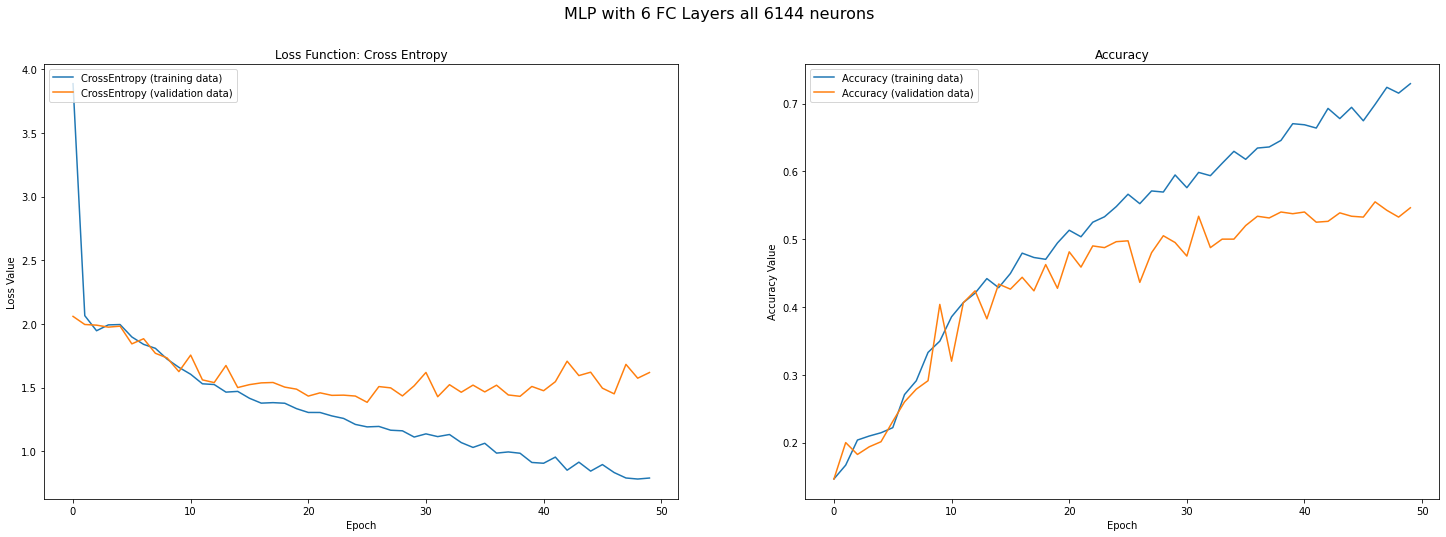

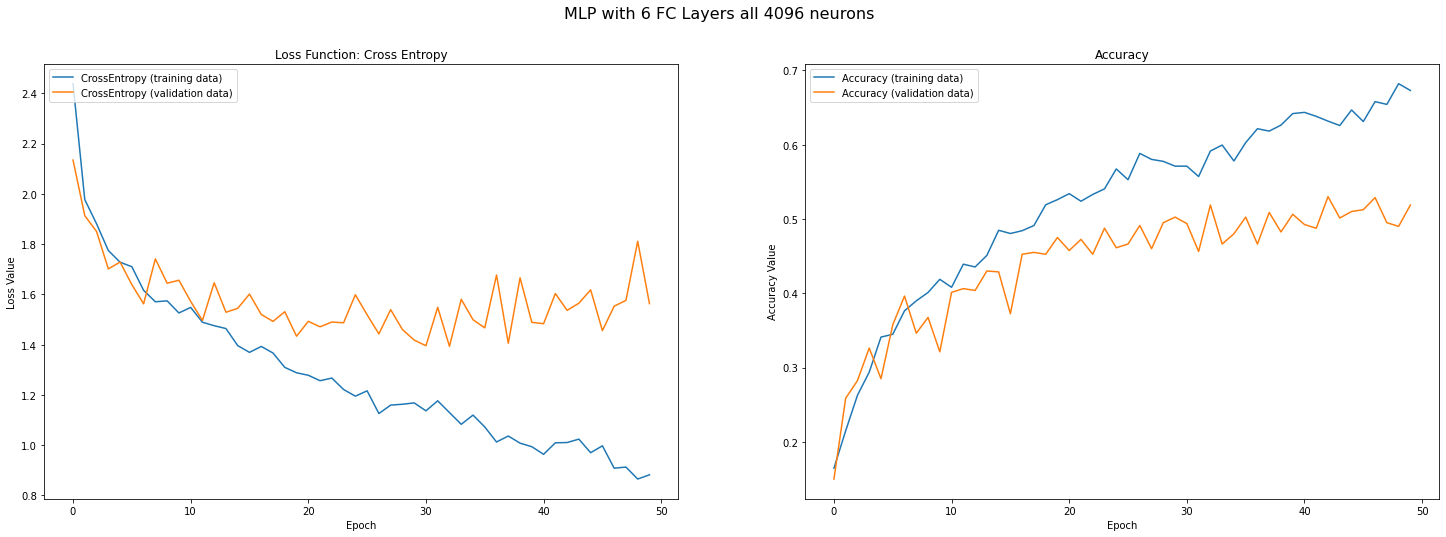

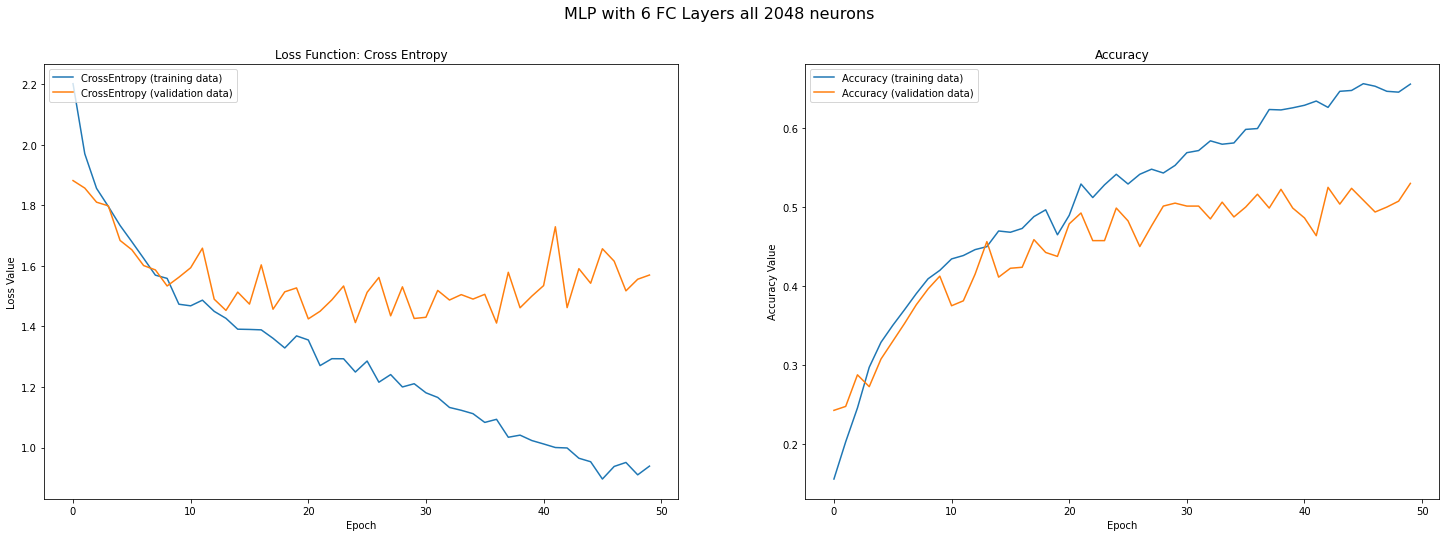

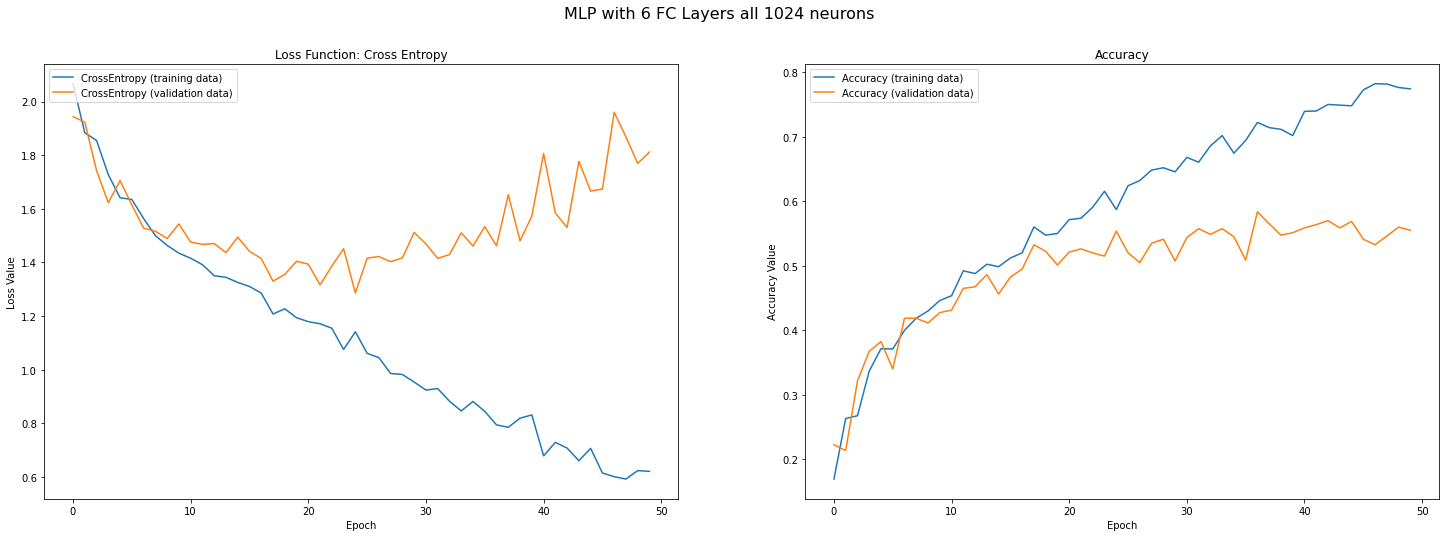

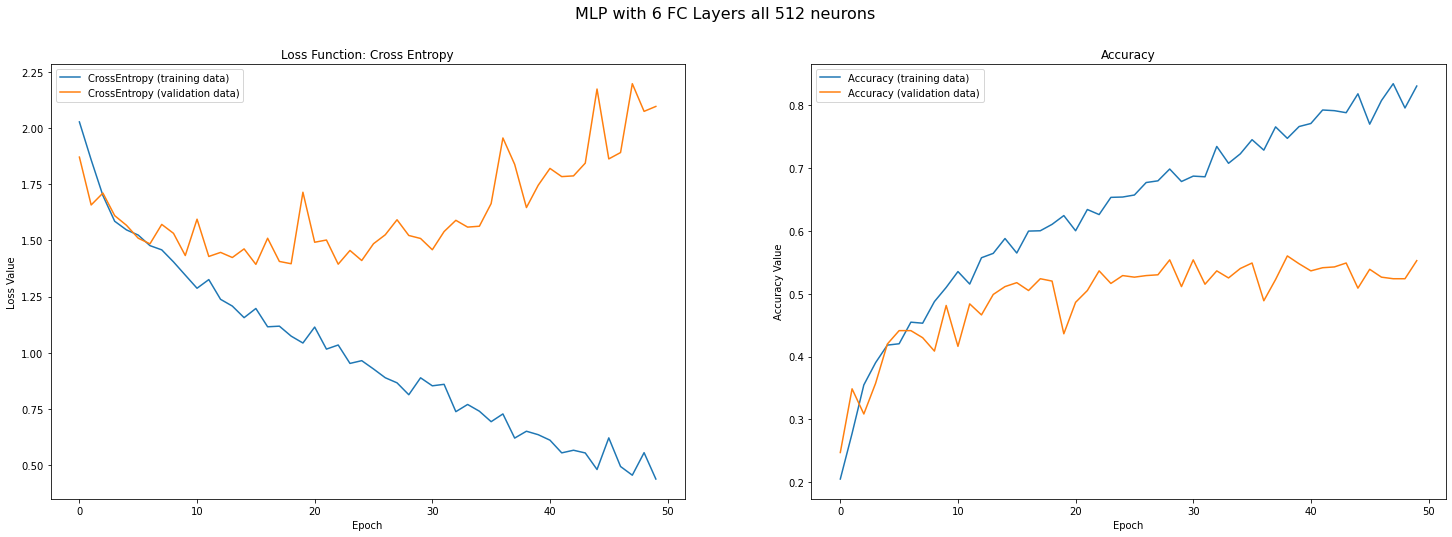

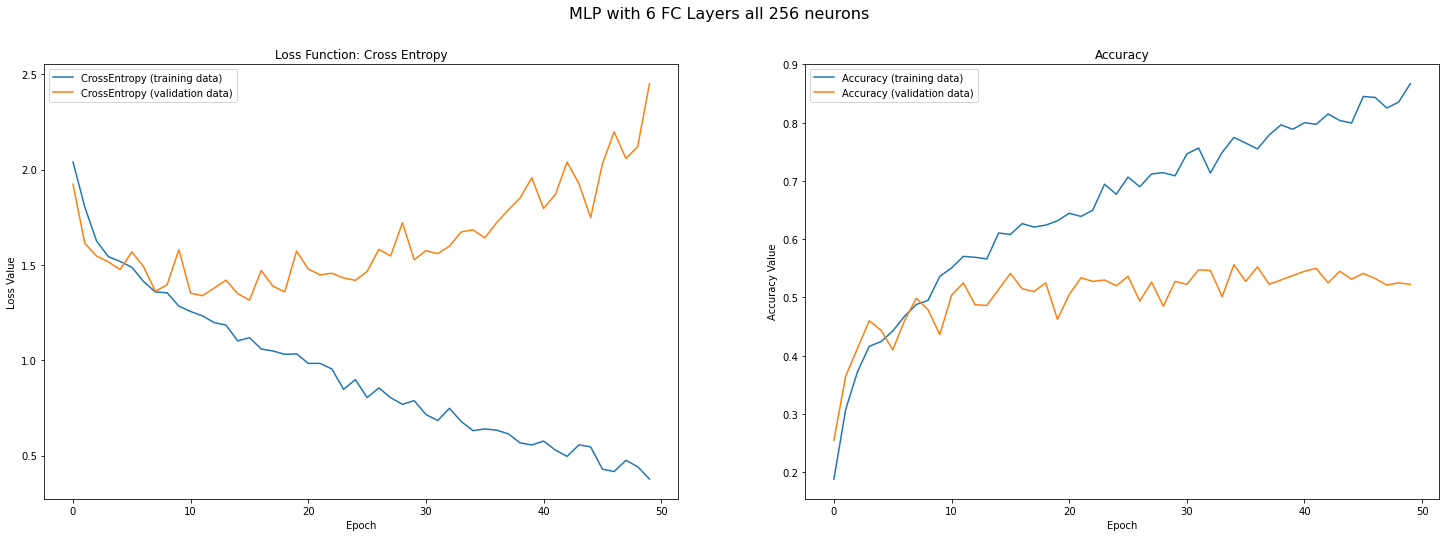

In [31]:
plot_loss_accuracy(history_6_big_6144, 'MLP with 6 FC Layers all 6144 neurons')
plot_loss_accuracy(history_6_big_4096, 'MLP with 6 FC Layers all 4096 neurons')
plot_loss_accuracy(history_6_big_2048, 'MLP with 6 FC Layers all 2048 neurons')
plot_loss_accuracy(history_6_big_1024, 'MLP with 6 FC Layers all 1024 neurons')
plot_loss_accuracy(history_6_big_512, 'MLP with 6 FC Layers all 512 neurons')
plot_loss_accuracy(history_6_big_256, 'MLP with 6 FC Layers all 256 neurons')

In [32]:
evaluate_model(model_6_big_6144, 'MLP with 6 FC Layers all 6144 neurons')
evaluate_model(model_6_big_4096, 'MLP with 6 FC Layers all 4096 neurons')
evaluate_model(model_6_big_2048, 'MLP with 6 FC Layers all 2048 neurons')
evaluate_model(model_6_big_1024, 'MLP with 6 FC Layers all 1024 neurons')
evaluate_model(model_6_big_512, 'MLP with 6 FC Layers all 512 neurons')
evaluate_model(model_6_big_256, 'MLP with 6 FC Layers all 256 neurons')

------------------------------------------------------------------------------------------
MLP with 6 FC Layers all 6144 neurons Train Score: 75.439 || Train Loss: 0.680
MLP with 6 FC Layers all 6144 neurons Test Score: 54.647 || Test Loss: 1.616
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
MLP with 6 FC Layers all 4096 neurons Train Score: 71.823 || Train Loss: 0.776
MLP with 6 FC Layers all 4096 neurons Test Score: 51.921 || Test Loss: 1.556
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
MLP with 6 FC Layers all 2048 neurons Train Score: 70.069 || Train Loss: 0.776
MLP with 6 FC Layers all 2048 neurons Test Score: 53.284 || Test Loss: 1.564
-----------------------------------------------------------------------------

### Conclusions
Following the same trend of the layers' study here we don't really see a big impact for number of neurons. The most performant was 512. We can see that equally to layers a very small or very big number of neurons also leads to bad performance, we need to choose a "proper" number of neurons per layer.